# Tutoriel de résolution d'un problème de machine learning : clustering de différents types de fleurs sans informations préalables

## Problématique étudiée

La problématique étudiée est le cas avec le dataset Iris. L'objectif de ce cas est de trouver des groupes de fleurs, sans information préalable sur le type de fleur disponible dans le dataset Iris.

Il s'agit donc d'un cas de **machine learning non supervisé**, et plus spécifiquement d'un cas de **clustering**.

Ce notebook va vous guider à travers ce cas concret de clustering, et va utiliser un modèle particulier de machine learning pour réaliser cette tâche : le **K-Means clustering**. Les parties suivantes sont dédiées à l'implémentation de ce modèle grâce à l'utilisation de la librairie scikit-learn.

## Code

### Importation des différentes librairies 

In [32]:
from sklearn.datasets import load_iris
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Importation du dataset 

In [3]:
iris = datasets.load_iris()

In [4]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

On voit grâce à la description détaillée qu'il s'agit d'un dataset qui classe les fleurs dans des types (targets) en fonction de la taille de leurs sépales et pétales (features). 

Il existe 3 targets (types de fleurs) : setosa, versicolor, virginica avec 50 fleurs dans chaque types.
On a 4 features numériques pour chaque fleur : sepal length (cm), sepal width (cm), petal length (cm), petal width (cm).

Nous sommes donc en possession de 150 lignes de 4 colonnes.

In [27]:
data, labels = load_iris(return_X_y=True)
(n_samples, n_features), n_fleur_type = data.shape, np.unique(labels).size

print(f"# fleur type: {n_fleur_type}; # échantillons: {n_samples}; # paramètres: {n_features}")

# fleur type: 3; # échantillons: 150; # paramètres: 4


### Définir notre benchmark d'évaluation

Nous allons d'abord définir notre benchmark d'évaluation. 
Au cours de ce benchmark, nous avons l'intention de comparer différentes méthodes d'initialisation pour KMeans. 
Notre benchmark va :

créer un pipeline qui mettra à l'échelle les données en utilisant un StandardScaler ;

entraîner et chronométrer l'adaptation du pipeline ;

mesurer la performance du clustering obtenu via différentes métriques.

In [20]:

def bench_k_means(kmeans, name, data, labels):
    """Benchmark pour évaluer les méthodes d'initialisation de KMeans.

    Paramètres
    ----------
    kmeans : instance KMeans
        Une instance de :class:`~sklearn.cluster.KMeans` avec l'initialisation
        déjà définie.
    name : str
        Nom donné à la stratégie. Il sera utilisé pour afficher les résultats dans un tableau.
    data : ndarray of shape (n_samples, n_features)
        Les données à regrouper.
    labels : ndarray of shape (n_samples,)
        Les étiquettes utilisées pour calculer les métriques de clustering, ce qui nécessite une certaine supervision.
    """

    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    #homogeneity: each cluster contains only members of a single class.
    #completeness: all members of a given class are assigned to the same cluster.
    #Both are bounded below by 0.0 and above by 1.0 (higher is better)
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Exécuter le benchmark

Nous allons comparer trois approches :

une initialisation utilisant kmeans++. Cette méthode est stochastique et nous allons exécuter l'initialisation 4 fois ;

une initialisation aléatoire. Cette méthode est également stochastique et nous allons exécuter l'initialisation 4 fois ;

une initialisation basée sur une projection PCA. En effet, nous utiliserons les composantes de l'ACP pour initialiser KMeans. Cette méthode est déterministe et une seule initialisation suffit.


In [30]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_fleur_type, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_fleur_type, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_fleur_type).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.021s	140	0.659	0.660	0.659	0.620	0.655	0.506
random   	0.015s	140	0.659	0.660	0.659	0.620	0.655	0.506
PCA-based	0.005s	191	0.535	0.657	0.590	0.433	0.584	0.519
__________________________________________________________________________________


###  Visualiser les résultats sur des données réduites par l'ACP

L'ACP permet de projeter les données de l'espace original à 64 dimensions dans un espace de dimension inférieure. Par la suite, nous pouvons utiliser l'ACP pour projeter les données dans un espace à 2 dimensions et tracer les données et les clusters dans ce nouvel espace.

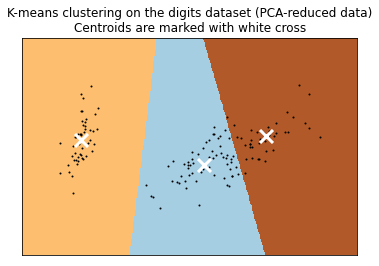

In [33]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_fleur_type, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [1]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(n_clusters=3)
model.fit(X)
model.predict(X)
plt.scatter(X[:,0], X[:,1], c=model.predict(X))
plt.scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1], c='r')
model.inertia_


In [ ]:
inertia = []
K_range(1,20)
for k in K_range:
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia)
plt.plot(K_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')

    